In [4]:
from torch.backends.mkl import verbose
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries


## Read data

In [5]:
electricity_consumption = pd.read_csv("../AnalysisAndPreprocessing/ProcessedData/Electricity-ResBusClimateLNI.csv")
electricity_consumption.drop(['Period start', 'Import values', 'Export values'], axis=1, inplace=True)
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Export prices,Export volumes,Import prices,Import volumes,Population
0,2010-01-01,67.866667,17.233333,15.766667,5.766667,18.333333,2.533333,2010.0,1.0,246.968,158.147,1072,1160,904,1360,299300.0
1,2010-02-01,71.333333,18.733333,17.800000,4.833333,7.500000,1.766667,2010.0,2.0,240.083,144.080,1072,1160,904,1360,299300.0
2,2010-03-01,46.000000,16.633333,14.366667,5.766667,22.666667,2.166667,2010.0,3.0,274.398,163.344,1072,1160,904,1360,299300.0
3,2010-04-01,41.733333,14.966667,13.966667,5.433333,17.666667,2.166667,2010.0,4.0,254.165,174.786,1112,1264,920,1476,299300.0
4,2010-05-01,149.600000,12.500000,12.500000,4.733333,14.500000,2.000000,2010.0,5.0,270.760,209.621,1112,1264,920,1476,299300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,45.133333,17.966667,15.400000,5.866667,19.000000,2.033333,2024.0,2.0,247.053,148.392,1362,1465,998,2381,358500.0
170,2024-03-01,61.866667,15.600000,13.333333,5.833333,22.333333,2.366667,2024.0,3.0,253.768,169.994,1362,1465,998,2381,358500.0
171,2024-04-01,117.100000,14.533333,13.333333,4.733333,12.000000,2.200000,2024.0,4.0,243.587,184.402,1433,1584,1029,2414,358500.0
172,2024-05-01,78.700000,10.800000,10.733333,4.600000,16.666667,1.900000,2024.0,5.0,262.416,246.995,1433,1584,1029,2414,358500.0


In [6]:
# read immigration data
# immigration = pd.read_csv("../immigrationData/immigration_population_type.csv")
# immigration['Date'] = pd.to_datetime(immigration['Date'], format='%Y-%m-%d')
# immigration['Date'] = immigration['Date'] - pd.offsets.MonthEnd(1) + pd.offsets.Day(1)
# electricity_consumption['Date'] = pd.to_datetime(electricity_consumption['Date'], format='%Y-%m-%d')
# electricity_consumption = electricity_consumption.merge(immigration, on='Date', how='left')


In [7]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

In [8]:
# training and validation split
train, val = ts.split_before(pd.Timestamp('2021-01-01'))

## Preprocessing

In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mae, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
transformer_target = Scaler(scaler)

train_target_og = train['Est. Total consumption (GWh)']
val_target_og = val['Est. Total consumption (GWh)']
train_target = transformer_target.fit_transform(train_target_og)
val_target = transformer_target.transform(val_target_og)

train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split past covariates
train_past_cov = train_transformed[[ 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec']]
val_past_cov = val_transformed[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']]

# replace missing value with the mean of column
train_past_cov = train_past_cov.pd_dataframe()
train_past_cov = train_past_cov.apply(lambda col: col.fillna(col.mean()))
train_past_cov = TimeSeries.from_dataframe(train_past_cov)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
series_transformed = series_transformed.pd_dataframe()
series_transformed = series_transformed.apply(lambda col: col.fillna(col.mean()))
series_transformed = TimeSeries.from_dataframe(series_transformed)

## Model training and testing

In [11]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [38]:
# with past covariates
model_gru = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=150,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU_with_past_cov_LNI",
    log_tensorboard=False,
    input_chunk_length=66,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=42,
    random_state=5
)

model_gru.fit(train_target,
   past_covariates = train_past_cov,
    verbose=False)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=100, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, n_epochs=150, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_GRU_with_past_cov_LNI, log_tensorboard=False, input_chunk_length=66, save_checkpoints=True, force_reset=True, output_chunk_length=42, random_state=5)

In [39]:
# without past covariates
model_gru_no_past_cov = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=150,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU_LNI",
    log_tensorboard=True,
    input_chunk_length=66,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=42,
    random_state=5
)

# with past covariates
model_gru_no_past_cov.fit(train_target,
    verbose=False)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=100, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, n_epochs=150, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_GRU_LNI, log_tensorboard=True, input_chunk_length=66, save_checkpoints=True, force_reset=True, output_chunk_length=42, random_state=5)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

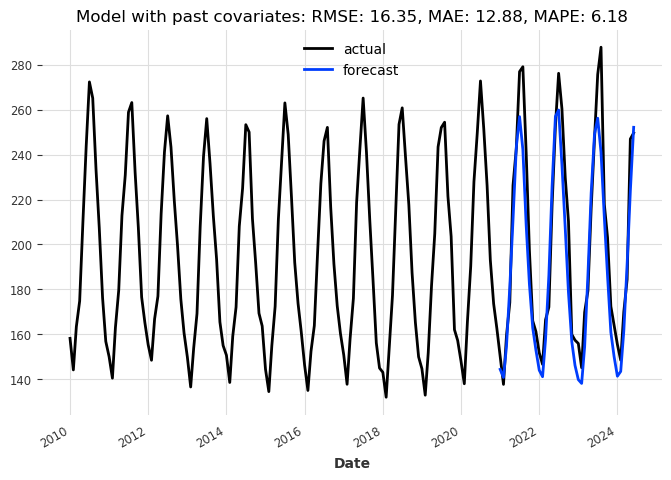

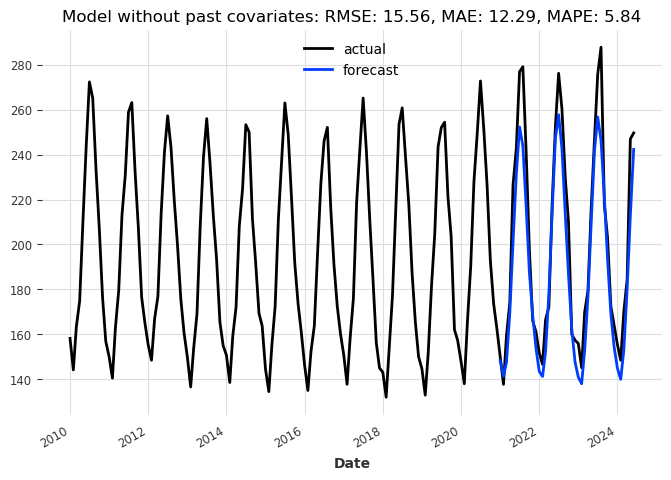

In [40]:
def eval_model(model):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    pred_series_reversed = transformer_target.inverse_transform(pred_series)
    ts['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series_reversed['Est. Total consumption (GWh)'].plot(label="forecast")
    if model.model_name.find("past_cov") != -1:
        plt.title("Model with past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series
    else:
        plt.title("Model without past covariates: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target_og, pred_series_reversed), mae(val_target_og, pred_series_reversed), mape(val_target_og, pred_series_reversed)))
        plt.legend()
        return pred_series

pred_series_transformed = eval_model(model_gru)
pred_series_transformed_no_past_cov = eval_model(model_gru_no_past_cov)

## Backtesting using 3 month forecast horizon

In [51]:
model_gru_backtest = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=150,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU",
    log_tensorboard=True,
    input_chunk_length=66,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=3,
    random_state=5
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

MAPE: 6.11%, RMSE: 30.42


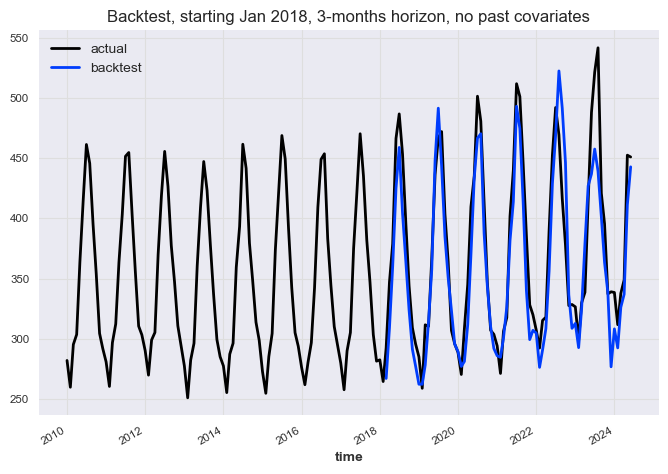

In [52]:
# without past covariates
backtest_series = model_gru_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed = transformer_target.inverse_transform(backtest_series)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon, no past covariates")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        )
    )
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

MAPE: 5.53%, RMSE: 28.50


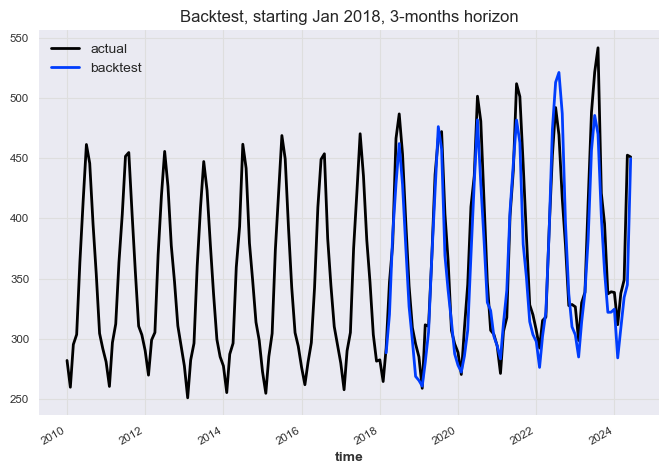

In [53]:
# with past covariates
backtest_series = model_gru_backtest.historical_forecasts(
    series_transformed['Est. Total consumption (GWh)'],
    past_covariates=series_transformed[['Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa']],
    start=pd.Timestamp("20180101"),
    forecast_horizon=3,
    retrain=True,
    verbose=False,
)

backtest_series_reversed = transformer_target.inverse_transform(backtest_series)

plt.figure(figsize=(8, 5))
ts['Est. Total consumption (GWh)'].plot(label="actual")
backtest_series_reversed.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 2018, 3-months horizon")
print(
    "MAPE: {:.2f}%, RMSE: {:.2f}".format(
        mape(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        ),
        rmse(
            ts['Est. Total consumption (GWh)'],
            backtest_series_reversed,
        )
    )
)